In [1]:
import torch
import matplotlib.pyplot as plt
import einops
import torchvision


In [2]:
# we have some images - batch of 16 that are 256x256x3
images = torch.rand(16, 3, 256, 256)

In [3]:
# model which processes the images 

class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.conv2 = torch.nn.Conv2d(16, 16, 3) 
        self.conv3 = torch.nn.Conv2d(16, 16, 3)
        self.conv4 = torch.nn.Conv2d(16, 1, 3)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [4]:
test = Model()(images)

In [5]:
# pretend this is good model - lets get the good parameters from it 

In [6]:
model = Model()
tensors = []
for name, tensor in model.state_dict().items():
    if 'weight' in name:
        tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels 
all_kernels = torch.cat(tensors)

In [7]:
n_features = 2 # pca to 2d 
means = all_kernels.mean(axis=0).unsqueeze(0)
centered_kernels = all_kernels - means
cov_matrix = torch.matmul(centered_kernels.cuda().T, centered_kernels.cuda()) # need cuda otherwise takes forever
v, w = torch.eig(cov_matrix, eigenvectors=True) # same comment as above
pca_reduced_points = torch.matmul(centered_kernels.detach(), w[:, :n_features].cpu()) # dont need gpu here, though
kernel_basis_vectors = w.view(9, 3, 3)

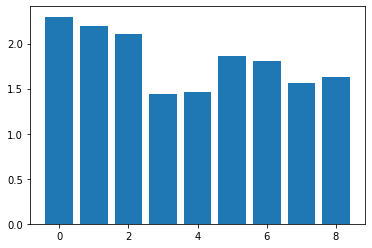

In [8]:
# the only thing this tells us is that our pca is very numerically unstable lol
plt.bar(torch.arange(v.size(0)), v[:, 0].cpu()) # get real part of eigenvalues
plt.show()

In [27]:
class Model_experiment(torch.nn.Module):
    
    def __init__(self, basis_vectors, device): # need device in __init__ because of weight assignment - https://discuss.pytorch.org/t/typeerror-cannot-assign-torch-cuda-floattensor-as-parameter-weight-torch-nn-parameter-or-none-expected/61765
        super().__init__()
        
        # conv basis weights
        self.cbw1 = torch.nn.parameter.Parameter(torch.rand(16, 3, 9, device=device))
        self.cbw2 = torch.nn.parameter.Parameter(torch.rand(16, 16, 9, device=device))
        self.cbw3 = torch.nn.parameter.Parameter(torch.rand(16, 16, 9, device=device))
        self.cbw4 = torch.nn.parameter.Parameter(torch.rand(10, 16, 9, device=device))
        
        self.linear = torch.nn.Linear(24*24, 1)
        
        # kernel basis vectors
        self.kbf = basis_vectors.to(device)
    def forward(self, x):
        # should be able to optimize parameters? 
        conv1_weight = torch.einsum('bld,dnm -> blnm', self.cbw1, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv1_weight, stride=1)
        x = torch.relu(x)
        conv2_weight = torch.einsum('bld,dnm -> blnm', self.cbw2, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv2_weight, stride=1)
        x = torch.relu(x)
        conv3_weight = torch.einsum('bld,dnm -> blnm', self.cbw3, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv3_weight, stride=1)
        x = torch.relu(x)
        conv4_weight = torch.einsum('bld,dnm -> blnm', self.cbw4, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv4_weight, stride=1)
        x = torch.relu(x)
        x = self.linear(x.view(x.size(0), 10, -1))
        return x.squeeze(-1)


In [28]:
class Model_control(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cbw1 = torch.nn.Conv2d(3, 16, 3)
        self.cbw2 = torch.nn.Conv2d(16, 16, 3)
        self.cbw3 = torch.nn.Conv2d(16, 16, 3)
        self.cbw4 = torch.nn.Conv2d(16, 10, 3)
        
        self.linear = torch.nn.Linear(24*24, 1)
        
    def forward(self, x):
        x = self.cbw1(x)
        x = torch.relu(x)
        x = self.cbw2(x)
        x = torch.relu(x)
        x = self.cbw3(x)
        x = torch.relu(x)
        x = self.cbw4(x)
        x = torch.relu(x)
        x = self.linear(x.view(x.size(0), 10, -1))
        return x.squeeze(-1)


In [29]:
device = 'cuda:2'
model_control = Model_control().to(device)

### Train some stuff, see if it actually works (MNIST)

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    acc = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        out_softmax = torch.nn.functional.softmax(output, dim=-1)
        _, idx = torch.max(out_softmax, -1)
        acc += (idx == target).float().mean()
        loss.backward()
        optimizer.step()
        if (1+batch_idx) % 150 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy:'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),
                 acc.item()/150)
            acc_copy = acc.clone()
            acc *= 0
            yield acc_copy.item() / 150


In [14]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
trainset = torchvision.datasets.CIFAR10(root='data2', train=True, download=True, transform=transform)
# trainset = torchvision.datasets.MNIST('data', train=False,transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=32)


Extracting data2/cifar-10-python.tar.gz to data2


In [30]:
optimizer = torch.optim.Adam(model_control.parameters(), lr=3e-4)

In [145]:
# control run
# loss_control = []
epochs = 30
for epoch in range(1, epochs):
    for loss_val in train(model_control, device, train_loader, optimizer, epoch):
        loss_control.append(loss_val)


Train Epoch: 1 [4768/50000 (10%)]	Loss: 1.010902	Accuracy: 0.645625
Train Epoch: 1 [9568/50000 (19%)]	Loss: 0.819527	Accuracy: 0.6183333333333333
Train Epoch: 1 [14368/50000 (29%)]	Loss: 1.048664	Accuracy: 0.6204166666666666
Train Epoch: 1 [19168/50000 (38%)]	Loss: 1.100863	Accuracy: 0.6235416666666667
Train Epoch: 1 [23968/50000 (48%)]	Loss: 1.003893	Accuracy: 0.6195833333333334
Train Epoch: 1 [28768/50000 (58%)]	Loss: 1.010216	Accuracy: 0.635
Train Epoch: 1 [33568/50000 (67%)]	Loss: 1.030761	Accuracy: 0.6229166666666667
Train Epoch: 1 [38368/50000 (77%)]	Loss: 1.057224	Accuracy: 0.6122916666666667
Train Epoch: 1 [43168/50000 (86%)]	Loss: 1.231648	Accuracy: 0.618125
Train Epoch: 1 [47968/50000 (96%)]	Loss: 1.017509	Accuracy: 0.6235416666666667
Train Epoch: 2 [4768/50000 (10%)]	Loss: 0.999099	Accuracy: 0.645625
Train Epoch: 2 [9568/50000 (19%)]	Loss: 0.817919	Accuracy: 0.62125
Train Epoch: 2 [14368/50000 (29%)]	Loss: 1.045815	Accuracy: 0.62125
Train Epoch: 2 [19168/50000 (38%)]	Loss: 1

In [146]:
# control run
# loss_control2 = []
epochs = 30
model_control2 = Model_control().to(device)
optimizer2 = torch.optim.Adam(model_control2.parameters(), lr=3e-4)
for epoch in range(1, epochs):
    for loss_val in train(model_control2, device, train_loader, optimizer2, epoch):
        loss_control2.append(loss_val)


Train Epoch: 1 [4768/50000 (10%)]	Loss: 2.327898	Accuracy: 0.15791666666666668
Train Epoch: 1 [9568/50000 (19%)]	Loss: 2.123215	Accuracy: 0.19895833333333332
Train Epoch: 1 [14368/50000 (29%)]	Loss: 2.119751	Accuracy: 0.19395833333333334


KeyboardInterrupt: 

In [147]:
# control run
# loss_control3 = []
epochs = 30
# model_control3 = Model_control().to(device)
# optimizer3 = torch.optim.Adam(model_control3.parameters(), lr=3e-4)
for epoch in range(1, epochs):
    for loss_val in train(model_control3, device, train_loader, optimizer3, epoch):
        loss_control3.append(loss_val)


Train Epoch: 1 [4768/50000 (10%)]	Loss: 1.560789	Accuracy: 0.333125
Train Epoch: 1 [9568/50000 (19%)]	Loss: 1.648169	Accuracy: 0.33875
Train Epoch: 1 [14368/50000 (29%)]	Loss: 1.560525	Accuracy: 0.34770833333333334
Train Epoch: 1 [19168/50000 (38%)]	Loss: 1.701597	Accuracy: 0.35479166666666667
Train Epoch: 1 [23968/50000 (48%)]	Loss: 1.778425	Accuracy: 0.38604166666666667


KeyboardInterrupt: 

In [148]:
tensors = []
for name, tensor in model_control.state_dict().items():
    if ('weight' in name) & ('linear' not in name):
        tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels 
# for name, tensor in model_control2.state_dict().items():
#     if ('weight' in name) & ('linear' not in name):
#         tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels 
# for name, tensor in model_control3.state_dict().items():
#     if ('weight' in name) & ('linear' not in name):
#         tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels 
all_kernels = torch.cat(tensors).cpu()

In [149]:
all_kernels.shape

torch.Size([720, 9])

In [150]:
n_features = 2 # pca to 2d 
means = all_kernels.mean(axis=0).unsqueeze(0)
centered_kernels = all_kernels - means
cov_matrix = torch.matmul(centered_kernels.cuda().T, centered_kernels.cuda()) # need cuda otherwise takes forever
v, w = torch.eig(cov_matrix, eigenvectors=True) # same comment as above
pca_reduced_points = torch.matmul(centered_kernels.detach(), w[:, :n_features].cpu()) # dont need gpu here, though
kernel_basis_vectors = w.view(9, 3, 3)

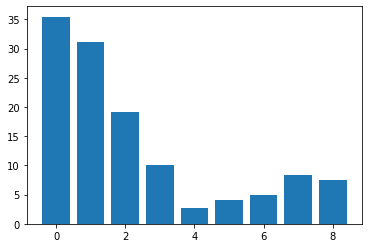

In [151]:
# the only thing this tells us is that our pca is very numerically unstable lol
plt.bar(torch.arange(v.size(0)), v[:, 0].cpu()) # get real part of eigenvalues
plt.show()

In [172]:
class Model_experiment(torch.nn.Module):
    
    def __init__(self, basis_vectors, device): # need device in __init__ because of weight assignment - https://discuss.pytorch.org/t/typeerror-cannot-assign-torch-cuda-floattensor-as-parameter-weight-torch-nn-parameter-or-none-expected/61765
        super().__init__()
        
        # conv basis weights
        norm_divisor = 10
        self.cbw1 = torch.nn.parameter.Parameter((torch.rand(16, 3, 4, device=device)-.5)/norm_divisor)
        self.cbw2 = torch.nn.parameter.Parameter((torch.rand(16, 16, 4, device=device)-.5)/norm_divisor)
        self.cbw3 = torch.nn.parameter.Parameter((torch.rand(16, 16, 4, device=device)-.5)/norm_divisor)
        self.cbw4 = torch.nn.parameter.Parameter((torch.rand(10, 16, 4, device=device)-.5)/norm_divisor)
        
        self.linear = torch.nn.Linear(24*24, 1)
        
        # kernel basis vectors
        self.kbf = basis_vectors.to(device)
    def forward(self, x):
        # should be able to optimize parameters? 
        conv1_weight = torch.einsum('bld,dnm -> blnm', self.cbw1, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv1_weight, stride=1)
        
        conv2_weight = torch.einsum('bld,dnm -> blnm', self.cbw2, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv2_weight, stride=1)
        
        conv3_weight = torch.einsum('bld,dnm -> blnm', self.cbw3, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv3_weight, stride=1)
        
        conv4_weight = torch.einsum('bld,dnm -> blnm', self.cbw4, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv4_weight, stride=1)
        
        x = self.linear(x.view(x.size(0), 10, -1))
        return x.squeeze(-1)


In [173]:
model_ex = Model_experiment(kernel_basis_vectors[:4], device).to(device)

In [174]:
optimizer_ex = torch.optim.Adam(model_ex.parameters(), lr=5e-4)

In [175]:
# control run
loss_ex = []
epochs = 30
for epoch in range(1, epochs):
    for loss_val in train(model_ex, device, train_loader, optimizer_ex, epoch):
        loss_ex.append(loss_val)


Train Epoch: 1 [4768/50000 (10%)]	Loss: 2.235107	Accuracy: 0.10708333333333334
Train Epoch: 1 [9568/50000 (19%)]	Loss: 2.262482	Accuracy: 0.178125
Train Epoch: 1 [14368/50000 (29%)]	Loss: 2.218242	Accuracy: 0.19520833333333334
Train Epoch: 1 [19168/50000 (38%)]	Loss: 1.907750	Accuracy: 0.20895833333333333
Train Epoch: 1 [23968/50000 (48%)]	Loss: 2.048964	Accuracy: 0.23
Train Epoch: 1 [28768/50000 (58%)]	Loss: 2.299437	Accuracy: 0.234375
Train Epoch: 1 [33568/50000 (67%)]	Loss: 2.073807	Accuracy: 0.24270833333333333
Train Epoch: 1 [38368/50000 (77%)]	Loss: 2.100562	Accuracy: 0.25875
Train Epoch: 1 [43168/50000 (86%)]	Loss: 2.297457	Accuracy: 0.24770833333333334
Train Epoch: 1 [47968/50000 (96%)]	Loss: 1.913155	Accuracy: 0.259375
Train Epoch: 2 [4768/50000 (10%)]	Loss: 2.015248	Accuracy: 0.26708333333333334
Train Epoch: 2 [9568/50000 (19%)]	Loss: 2.018712	Accuracy: 0.255625
Train Epoch: 2 [14368/50000 (29%)]	Loss: 2.094684	Accuracy: 0.2679166666666667
Train Epoch: 2 [19168/50000 (38%)]	L

KeyboardInterrupt: 

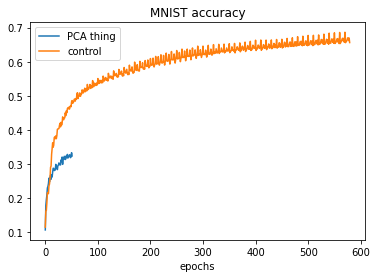

In [176]:
plt.plot(loss_ex, label='PCA thing')
plt.plot(loss_control, label='control')
plt.legend()
plt.title('MNIST accuracy')
plt.xlabel('epochs')
plt.show()
